# Imports and Data Loading

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='seaborn')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,MaxAbsScaler,LabelEncoder,OrdinalEncoder
import lightgbm as lgb 
from lightgbm import LGBMClassifier 
import os
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.datasets import make_classification 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
import pickle
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier,VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Reading the train and test files.
train=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Exploratory Data Analysis (EDA)

In [29]:
train.shape

(20000, 22)

*Observation*: 
* The training data has total 22 columns and 20000 tokens. One of the column being the Target column, we have 21 features.

In [30]:
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


*Observation*:
* On looking at few rows of the data set, it is observed that we have all the detailes realted to the crime, such as exact location of the place (inculding latitude and longitude), Time occured, modus operandi etc.
* All this rows seems very informatic and will help in building the model.


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

*Observation*:
* It can be seen that we have several rows with numerical datatype and some are categorical as well. 
* Non-null column of the above code output also shows that several column has significant number of null values. 

In [32]:
train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


*Observation*:
* Minimum value of colum *Victim_Age* is -2, which obviously signifies that we have to treat age<0 as null values and handle those unknowns.


In [33]:
train.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

*Observation*:
* *Cross_Street, Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code,Weapon_Description* are the columns which have null values directly as `np.nan`, and all of them are categorical columns.

<Axes: >

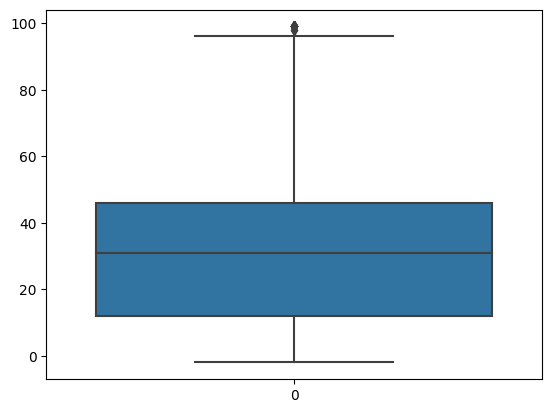

In [34]:
sns.boxplot(train['Victim_Age'])

*Observation*:
* The box plot above signifies that there are several out liers in the Victim_Age column.
* But most of the criminals have age from around 18 to 45. 

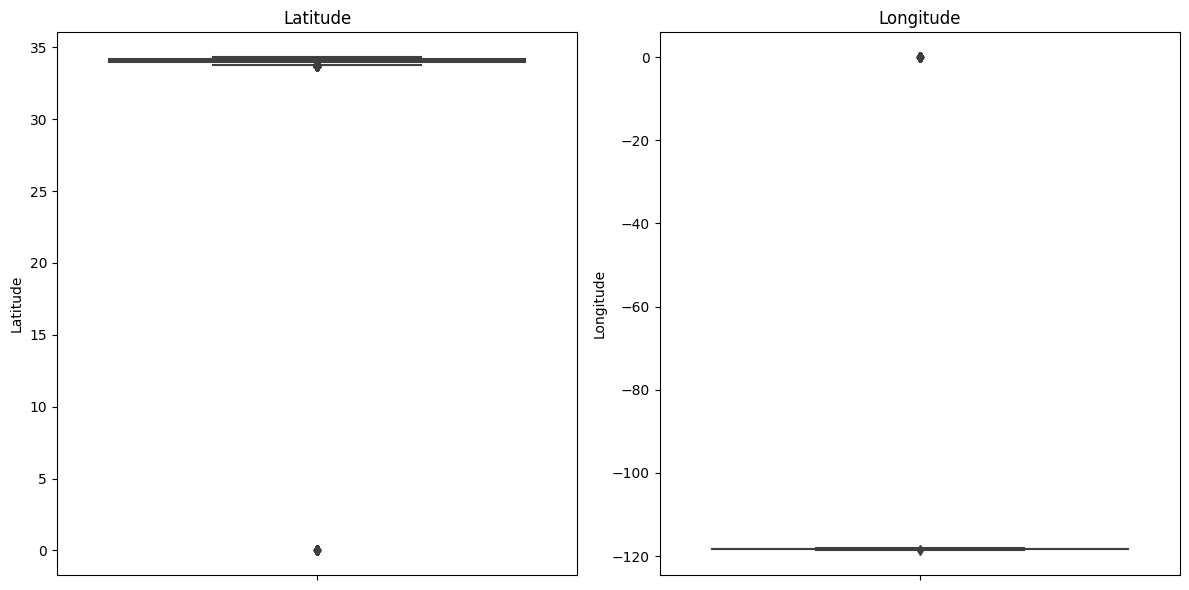

In [35]:
# box plot of latitude and longitude.
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for Latitude
sns.boxplot(y=train['Latitude'], ax=axes[0])
axes[0].set_title('Latitude')

# Boxplot for Longitude
sns.boxplot(y=train['Longitude'], ax=axes[1])
axes[1].set_title('Longitude')

plt.tight_layout()
plt.show()

*Observations*:
* Both Latitude and Longitude have distribution in small range of values, i.e. Latitude has all values around 34 degrees and Longitude is around -120 degrees.
* This close cluter, signifies that we have data of one proper region of a country, may be a state or district.
* We can also see the outliers in both Longitude and Latitude, which is at 0 degrees. This are most likely unknown/null values.

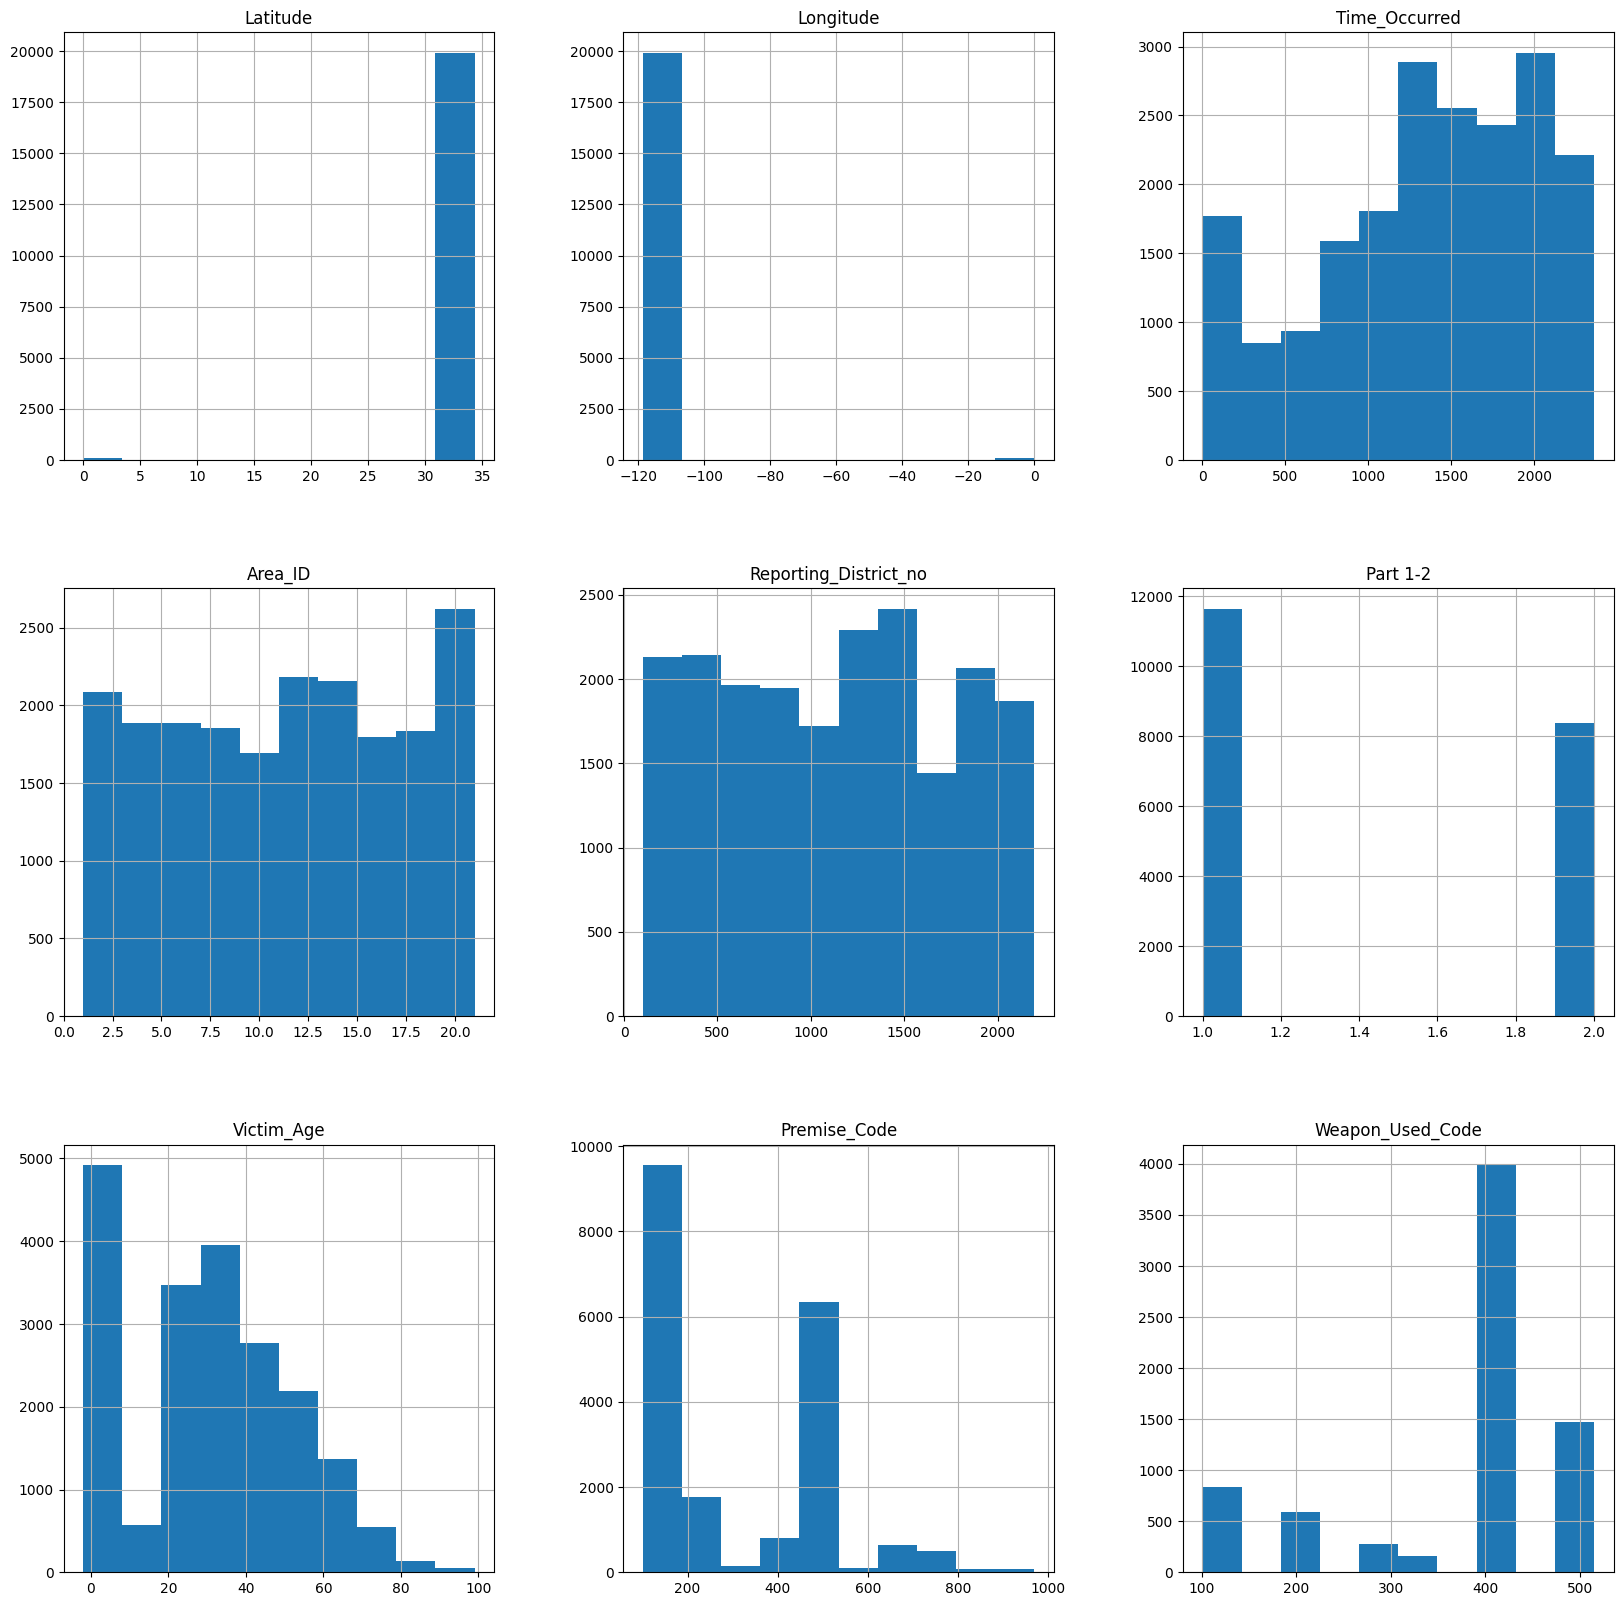

In [36]:
train.hist(figsize=(20,20));

*Observation*:
* The above code output shows us the histogram plot of the relevent columns with numerical values in it. 
* We can see distribution of columns such as victim_Age, which has significant number of tokens with less than 0 age.
* *part 1-2* column has only two unique categories in it, 1 and 2.
* Histogram of *Time Occured* column gives us important insight about the distribution of time over hours of day, we can observe that the amount of crime in second half of the day is significantly higher than the earlier hours of the day.

<Axes: >

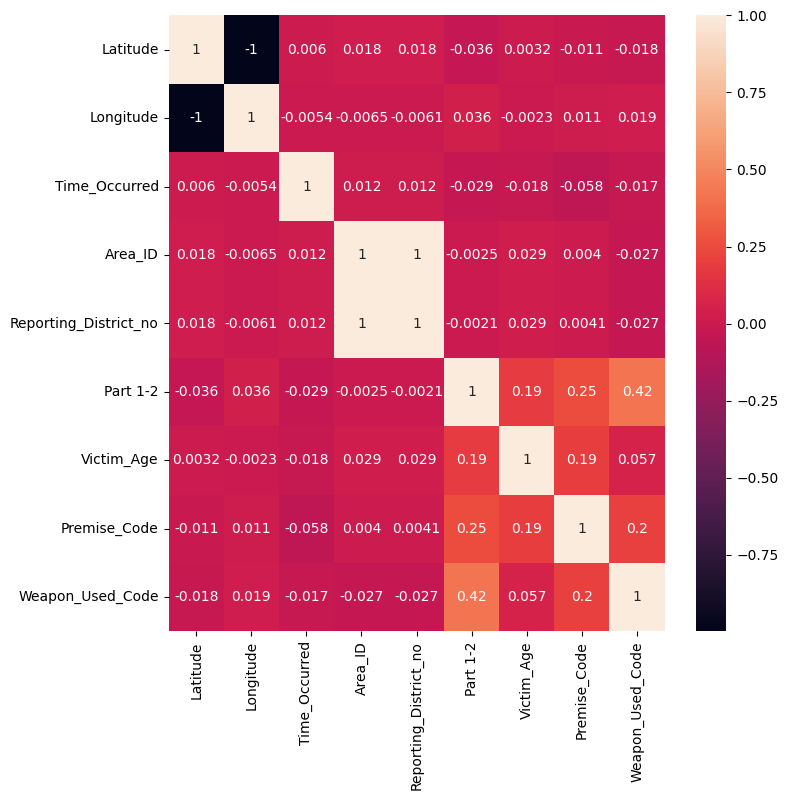

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(train.select_dtypes(exclude=object).corr(),annot=True) #Excluded the coulms with strings input

*Observations*:
* Columns *Area_ID* and *Reporting_District_no* are full corelated.
* Other than that, there is not much coorelation between the feature columns except *Part 1-2* and *Weapon_used_code* with correlation coefficient of **0.42**.
* There is also a minor corelation between columns like *Premise_Code*, *Victim_Age* and *Weapon_used_code*.

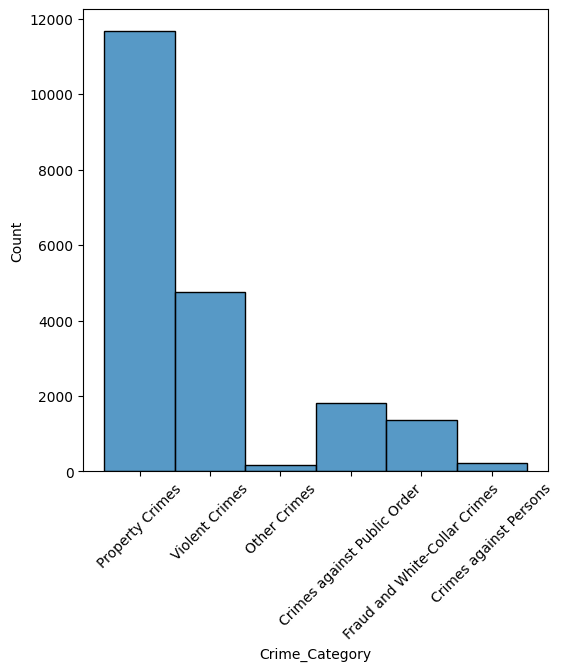

In [38]:
plt.figure(figsize=(6,6))
sns.histplot(train['Crime_Category']) #Plooting histogram of target column
plt.xticks(rotation=45); #keeping the angle of labels to avoid overlap


*Observations*:
* This historam is very important for our analysis and model building since it represents the behaviour of the target column.
* We can see that there is a class imbalance. Some crimes such as 'Property Crimes' and 'Violent Crimes' are much more frequent than 'Other Crimes' and 'Crimes against Persons'.

<h3> Histograms of Categorical Columns

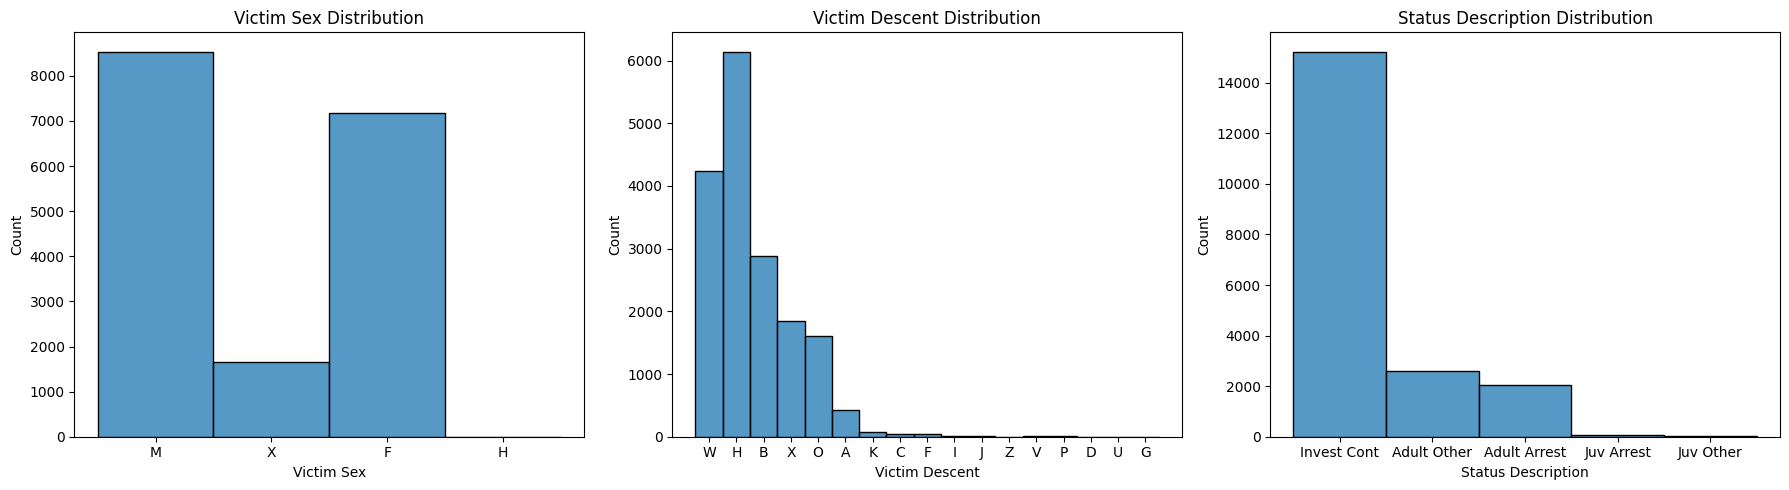

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
# the histogram for Victim_Sex
sns.histplot(train['Victim_Sex'], ax=axes[0]) #making the plot
#labling the graph
axes[0].set_title('Victim Sex Distribution')
axes[0].set_xlabel('Victim Sex')
axes[0].set_ylabel('Count')

# the histogram for Victim_Descent
sns.histplot(train['Victim_Descent'], ax=axes[1])
#labling the graph
axes[1].set_title('Victim Descent Distribution')
axes[1].set_xlabel('Victim Descent')
axes[1].set_ylabel('Count')

# the histogram for Status_Description
sns.histplot(train['Status_Description'], ax=axes[2])
#labling the graph
axes[2].set_title('Status Description Distribution')
axes[2].set_xlabel('Status Description')
axes[2].set_ylabel('Count')

#adjusting the layout to fit the frame.
plt.tight_layout()
plt.show()

*Observations*:
* The above code output shows distribution of different categories of our three categorical columns *Victim Sex*, *Victim Descent* and *Status Discription*.
* The *Victim Sex* column have most of the tokens as male or female but we have two other values as well 'X' and 'H', which are relative less occuring,
* The *Victim Descent* column has many different values, but most common descent is 'H' followed by 'W' and others.
* The *Status Discription* has 5 unique values. The most common is *Investment Cont.* which means that investment is continouning. And then we have some token with values such as 'Adult Other','Adult Arrest' etc.


In [40]:
train['Modus_Operandi']

0                                           0385
1        0906 0352 0371 0446 1822 0344 0416 0417
2                                      0329 1202
3                                      0329 1300
4                  0416 0945 1822 0400 0417 0344
                          ...                   
19995                        0416 0446 2004 0913
19996                   1822 0209 0344 1414 1420
19997                             0344 1822 1420
19998              1202 2038 0913 0602 1242 0553
19999                                        NaN
Name: Modus_Operandi, Length: 20000, dtype: object

*Observation*:
* The modus operandi feature is more unique than other features and therfore will require different pre-processing.
* Since it containes all the codes of modus operandies, it will be usefull to extract information for each modus operandi that column has.

# Pre_processing

<h3> We will start with handling the unknowns in Victim_Age column </h3>

> We already figured out that unknows of the column are with <=0 value. 

In [41]:
train.loc[train['Victim_Age']<=0].shape[0]

4834

*Observations*: 
* So there is significant number of **4834** tokens with unknown value for the age column out of **20000** tokens.
* To tackle this, we will try to impute it with median value of the remaining column tokens.

In [42]:
train['Victim_Age'].median()

31.0

*Observations*:
* The median for the age column is *31* years.
* We will impute this value to appropriate missing/unknown values. 


In [43]:
#loading the test and train file again just to be sure of it's intergity.
train=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test=pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

#here we replaced less than zero value with 0.
train['Victim_Age']=train['Victim_Age'].replace([-1,-2],0)
test['Victim_Age']=test['Victim_Age'].replace([-1,-2],0)

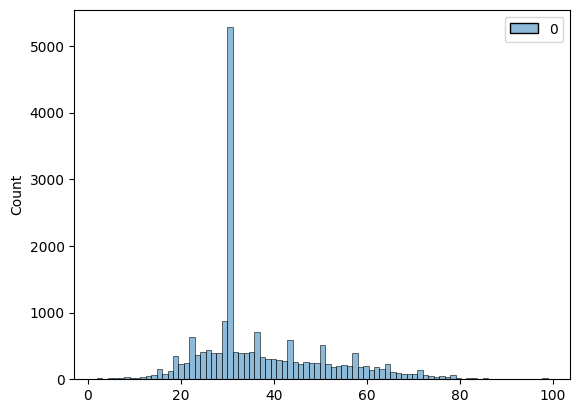

In [44]:
#Creating a simpleimputer using sklearn library and filling the missing values with the median of train set.
imputer=SimpleImputer(missing_values=0,strategy='constant',fill_value=train['Victim_Age'].median())

#imputing on both train and test set.
sns.histplot(imputer.fit_transform(np.array(train['Victim_Age']).reshape(-1,1)))
train['Victim_Age']=imputer.fit_transform(np.array(train['Victim_Age']).reshape(-1,1))
test['Victim_Age']=imputer.transform(np.array(test['Victim_Age']).reshape(-1,1))

*Observation*:
* We can see that less than 0 values are imputed with 31, which can be observed being the highest occruring age now in the dataset.

<h2> Feature Engineering
<h3> Here, we will use the feature that we already have to create some more meaningful features that we can utilize for more efficient model.

In [45]:
def split_date_columns(df):
    
    #Makes date_occured and date_reported column to datetime data type from string.
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
    
    #Now, we will use inbuilt fuctions of datetime datatype to extract useful information such as day,
    # month and year.For all of that we created a new column, which will now act as a new feature
    df['occurred_month'] = df['Date_Occurred'].dt.month
    df['occurred_day'] = df['Date_Occurred'].dt.day
    df['occurred_year'] = df['Date_Occurred'].dt.year
    df['reported_month'] = df['Date_Reported'].dt.month
    df['reported_day'] = df['Date_Reported'].dt.day
    df['reported_year'] = df['Date_Reported'].dt.year
    
    #One important information could be the difference in days between the crime occured and it being reported.
    #We created a new feature which is difference in days between the occured and reported.
    df['Day_difference']=df['reported_day']-df['occurred_day']
    return df


*Obseravation* :
* We have two columns with date information *Date_Occured* and *Date_Reported*.
* The function above extracts important information out of it and creates **7** different features out of 2.

In [46]:
# This function is for handling modus operandi column.
def one_hot_encode_modus_operandi(df, all_possible_mo=None):
    modus_operandi_col = 'Modus_Operandi'
    
    #filling null values (np.nan) will empty string since that is easier to handle.
    df[modus_operandi_col] = df[modus_operandi_col].fillna('')
    
    #Splitng the modus opernadi column to strings by spcae, so it will create a list of all the modus operandis of that column.
    modus_operandi_split = df[modus_operandi_col].str.split()
    
    #It is also vital info. that how much modus opernadi one row has, so we creat a new feature for it here.
    df['total_modus_operandi'] = modus_operandi_split.apply(len)
    
    #Creating a dummy columns for all modus operandies. And this will replicate a one hot encoding for modus operandies. 
    modus_operandi_dummies = pd.get_dummies(modus_operandi_split.apply(pd.Series).stack(), prefix='MO').groupby(level=0).sum()
    
    #We need constiency in the columns of train and test set.
    #below line make sures that if we  maintain new modus opernadi in test set then to not include it,
    #because it will create incositency in the columns of train and test.
    if all_possible_mo is not None:
        for mo in all_possible_mo:
            if mo not in modus_operandi_dummies.columns:
                modus_operandi_dummies[mo] = 0
        modus_operandi_dummies = modus_operandi_dummies[all_possible_mo]
    modus_operandi_dummies = modus_operandi_dummies.reindex(df.index, fill_value=0)
    
    #concatinating the one-hot encoded modus_operandi_columns with original dataset.
    df = pd.concat([df, modus_operandi_dummies], axis=1)
    return df

#saving unique value of modus operandis from train set, which will be later used for train and test set.
all_possible_mo = pd.get_dummies(train['Modus_Operandi'].str.split().apply(pd.Series).stack(), prefix='MO').columns.tolist()



*Observation*: 
* The above function creats one hot encoding for all unique modus operandies.
* This is a cruciel step in feature handling and plays significant role in model accuracy.

<h2> Feature Selection
<h3> Now that we have done feature engineering. We have some features that might not be useful and are repetative, we will handle those now.

In [47]:
#applying feature engineering functions on train set.
df=split_date_columns(train)
df=one_hot_encode_modus_operandi(train,all_possible_mo)

#dropping the unnecassary/repitative columns.
df.drop(['Date_Occurred','Date_Reported','Location','Cross_Street','Latitude','Longitude','Area_Name','Premise_Description','Weapon_Description','Status_Description','Modus_Operandi'],axis=1,inplace=True)

***Reasons for dropping particular columns***:
* ***'Date_Occurred','Date_Reported','Modus_Operandi'*** : We already extracted usefull information out of these columns.
* ***'Location','Cross_Street','Latitude','Longitude'***: The *Area_Id* column was providing the all the information relevent to these columns, and it was observed that removing or keeping this columns was not effecting the model results.
* ***'Area_Name','Premise_Description','Weapon_Description','Status_Description'***: This columns are just more descriptive version of other categorical columns such as *'Aread_ID','Premise', 'Weapon_used_code'*, etc.

In [48]:
#Seprating features and traget column.
X=df.drop(['Crime_Category'],axis=1)
y=df['Crime_Category']

In [49]:
#creating list of categorical and numerical features. So, that we can apply seperate pre_processing to them.
categorical=['Area_ID', 'Reporting_District_no', 'Part 1-2','Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code','Weapon_Used_Code', 'Status']

#to get get numerical columns, we are 'subtracting' categorical columns from all the columns of dataframe. Modus operandi columns will be kept in numerical.
numerical=list(set(list(X.columns)).difference(categorical))

# Non-Ensemble Models

In [24]:
#We are applying column transformer here, for categorical variables it will apply One-hot encoding.
# And for numercial varibales it will minmaxscaling.
trans=ColumnTransformer([('categorical',OneHotEncoder(handle_unknown='ignore'),categorical),
                    ('numerical',MinMaxScaler(),numerical)])
#transfroming the the train set
X_trans=trans.fit_transform(X)

#encoding labels, since they are strings right now.
label_encode=LabelEncoder()
y_trans=label_encode.fit_transform(y)

#splitting data into train and test. Keeping test size to be 30%.
X_train,X_test,y_train,y_test=train_test_split(X_trans,y_trans,random_state=0,test_size=0.3)

In [25]:
#Applying preprocessing on test set.
sub_test=test.copy()
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

#applying feature engineering functions on test set.
sub_test=split_date_columns(sub_test)
sub_test=one_hot_encode_modus_operandi(sub_test,all_possible_mo)

#applying feature selection on test set.
sub_test.drop(['Date_Occurred','Date_Reported','Location','Cross_Street','Latitude','Longitude','Area_Name','Premise_Description','Weapon_Description','Status_Description','Modus_Operandi'],axis=1,inplace=True)

#transforming the test set with transfromer for treating categorical and numerical variables.
sub_test_trans=trans.transform(sub_test)

<h2> Dummy Model

In [26]:
dummy_model=DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train,y_train)
dummy_model.score(X_test,y_test)

0.5915

*Observation*
* The accracy for the dummy model is approximately **0.59**.
* So, dummy model with predicting most frequent class is predicting slighltly better than random guess.
* This also signifies that there is class imbalence in the dataset.

<h2> KNN Classifier model With hyperparameter tuning

In [34]:
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.91

In [32]:
#Setting the parameter grid
param_grid={'n_neighbors':[2,5,6]}

#making grid search instance with 3 fold cross-validation
knn_grid=GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=3,n_jobs=-1)

#fitting the model and checking the score
knn_grid.fit(X_train,y_train)
knn_grid.score(X_test,y_test)

0.91

*Observations*:
* KNN Classifier produces good accuracy of **0.91**.
* The hyperparameter tuning does not seem to imporove on it.

<h2> SVM Classifier with/without hyperparamter Tuning

In [29]:
#making a modal instance of SVM
svm=SVC(random_state=0)

#fitting the model on train set and checking the score for test.
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.9486666666666667

In [33]:
#takes time in running
#Setting the Parameter grid for SVM
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1,'auto']
}

#making a gridsearch instance with 5 fold cross-validation
svm_grid=GridSearchCV(SVC(random_state=0),param_grid=param_grid,cv=5,n_jobs=-1)

#fitting the model on train set and checking the score for test.
svm_grid.fit(X_train,y_train)
svm_grid.score(X_test,y_test)

0.9498333333333333

*Observations*:
* SVM produces good accuracy of **0.949**.
* The hyperparameter tuning does improve the result.


<h2> Logistic Regression model with/without Hyperparameter tuning.

In [30]:
#making a modal instance of Logistic Regression
log=LogisticRegression(random_state=0)

#fitting the model on train set and checking the score for test.
log.fit(X_train,y_train)
log.score(X_test,y_test)

0.9458333333333333

In [33]:
#Setting the Parameter grid for Logistic Regression
param_grid={'max_iter':[500,100,1000],
           'solver':['lbfgs', 'liblinear', 'sag', 'saga']}

#making a gridsearch instance with 5 fold cross-validation
log_grid=GridSearchCV(LogisticRegression(random_state=0),param_grid=param_grid,cv=5,n_jobs=-1)

#fitting the model on train set and checking the score for test.
log_grid.fit(X_train,y_train)
log_grid.score(X_test,y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9458333333333333

*Observations*:
* Though result is good enough in it self. And it is comparable to SVM.
* The result obtained with and without the Hyperparameter tunning are same.

<h1> Ensemble Models

**In ensemble models, we will handle categorical variables differently.
    Since, Ensemble models are not 'much' affected by the whether categorical variables are treated as one-hot encoding or ordinal encoding. So, we will apply ordinal encoding which is more efficient computationally.**

<h2> Preprcoessing for Ensemble Models

In [50]:
#A column transformer which applies Ordinal encoding to categorical variables and minmaxsscaling for numerical variables.
#We put -1 for unknown values, and it will act as different category in it self.
trans=ColumnTransformer([('categorical',OrdinalEncoder(unknown_value=-1,handle_unknown='use_encoded_value',encoded_missing_value=-1),categorical),
                    ('numerical',MinMaxScaler(),numerical)])

#transforming features dataset with new trasformer instance.
X_trans=trans.fit_transform(X)

#encoding labels
label_encode=LabelEncoder()
y_trans=label_encode.fit_transform(y)

#spliting the data into train test split.
X_train,X_test,y_train,y_test=train_test_split(X_trans,y_trans,random_state=0,test_size=0.3)

In [51]:
#Applying preprocessing on test set.
sub_test=test.copy()
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

#applying feature engineering functions on test set.
sub_test=split_date_columns(sub_test)
sub_test=one_hot_encode_modus_operandi(sub_test,all_possible_mo)

#applying feature selection on test set.
sub_test.drop(['Date_Occurred','Date_Reported','Location','Cross_Street','Latitude','Longitude','Area_Name','Premise_Description','Weapon_Description','Status_Description','Modus_Operandi'],axis=1,inplace=True)

#transforming the test set with transfromer for treating categorical and numerical variables.
sub_test_trans=trans.transform(sub_test)

## LGBM Classifier

In [38]:
#LGMB Classifier instance
lgb=LGBMClassifier(random_state=0,boosting_type='dart')
lgb.fit(X_train,y_train)
lgb.score(X_test,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 181
[LightGBM] [Info] Start training from score -4.422849
[LightGBM] [Info] Start training from score -2.401616
[LightGBM] [Info] Start training from score -2.705197
[LightGBM] [Info] Start training from score -4.776128
[LightGBM] [Info] Start training from score -0.545097
[LightGBM] [Info] Start training from score -1.417343


0.9541666666666667

*Observations*:
* As we can see that LGBM Classifier is performing better than all the previous ones.
* The accuracy on the validation set is around **0.95**.

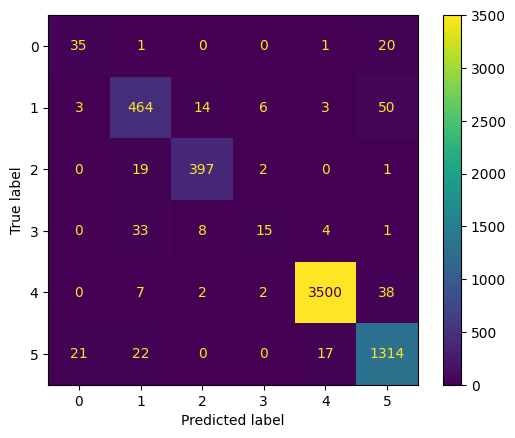

In [39]:
#Lets Observer the Confusion matrix of the LGBM Classifier
ConfusionMatrixDisplay.from_predictions(y_test,lgb.predict(X_test))

*Observations*:
* The confusion Matrix seems better. Where we can see the digonal to be much more frequient.
* We can though observe though that for class 3, that model is confusing class 3 for class 1. and something similar with class 5 and 1.

## XGB Classifier

In [43]:
#Making instance of XGB classifier.
xgb_classifier=xgb.XGBClassifier(random_state=0)

#fitting the model
xgb_classifier.fit(X_train,y_train)
xgb_classifier.score(X_test,y_test)

0.9571666666666667

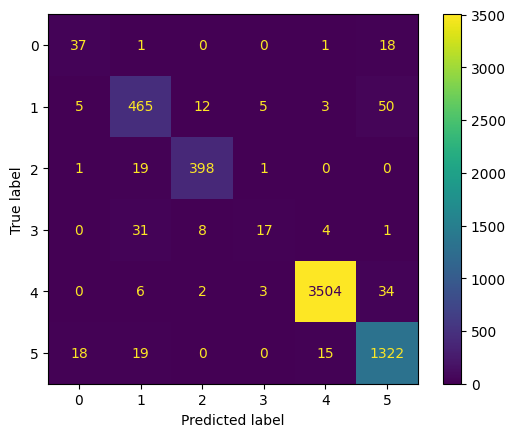

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test,xgb_classifier.predict(X_test))

*Observations*:
* We can see that the results for XGB boost are much more similar to that of LGB Classifier.
* Even the limitation on class 3 being confused to be class 1 is still there.

## Voting Classifier as XGB classifier and LGBM Classifier as estimators.

<h3>Till now, the best performing models are LGBM and XGboost, We will now apply Voting classifier using this two as estimators.

In [47]:
#Making instances of estimators for model.
model1 = xgb.XGBClassifier(random_state=1)
model2 = LGBMClassifier(random_state=1)

#making voting classifier with 'hard' voting ('soft' is not performing as good as 'hard')
voting = VotingClassifier(estimators=[('lgb', model2), ('xgb', model1)], voting='hard')

#fitting the model
voting.fit(X_train,y_train)
voting.score(X_test,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 181
[LightGBM] [Info] Start training from score -4.422849
[LightGBM] [Info] Start training from score -2.401616
[LightGBM] [Info] Start training from score -2.705197
[LightGBM] [Info] Start training from score -4.776128
[LightGBM] [Info] Start training from score -0.545097
[LightGBM] [Info] Start training from score -1.417343


0.9565

*Observation*:
* This model is turing out to be the best model, with best score on the leaderboard.
* We will plot Classificiation report for it and see if it can be further improved.

In [51]:
print(classification_report(y_test,voting.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63        57
           1       0.84      0.89      0.86       540
           2       0.95      0.95      0.95       419
           3       0.69      0.18      0.29        61
           4       0.99      0.99      0.99      3549
           5       0.93      0.96      0.94      1374

    accuracy                           0.96      6000
   macro avg       0.84      0.77      0.78      6000
weighted avg       0.96      0.96      0.95      6000



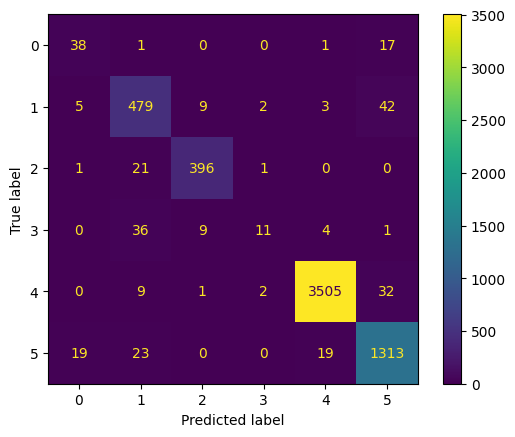

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test,voting.predict(X_test))

In [50]:
# Submitting the Voting Classifer model.

#inverse transforming the predictions.
voting_output=label_encode.inverse_transform(voting.predict(sub_test_trans))

#preparing output dataframe
ID=[i for i in range(1,5001)]
voting_result=pd.DataFrame(ID)

#imputing model output to the dataframe
voting_result['Crime_Category ']=voting_output
voting_result.columns=['ID', 'Crime_Category ']

#Updating the predictions in submission.csv file
voting_result.to_csv('submission.csv',index=False)

*Observations*:
* Till now, Voting classifier with LGBM and XGBosst as estimator is best peroforming.
* On looking at the Classification report, We can see that the class imbalance is taking a toll on the less occuring classes.
* The class *3* with just support of 61 tokens has accuracy of only ***0.26***. And it is still getting confused for class 1. And similar for class 0, which is getting predecited a bit more to be class 5
* To improve it even further, we can do SMOTE to see if the result is improving or not.

# Stacking

In [57]:
#Making instances of estimators for model.
model1 = GradientBoostingClassifier(random_state=1)
model2 = SVC(random_state=1)

#making voting classifier with 'hard' voting ('soft' is not performing as good as 'hard')
stacking = StackingClassifier(estimators=[('lgb', model2), ('grad', model1)],final_estimator=RandomForestClassifier(random_state=0))

#fitting the model
stacking.fit(X_train,y_train)
stacking.score(X_test,y_test)

0.9533333333333334

# SMOTE (Synthetic Minority Oversampling Technique)

In [38]:
#Making a SMOTE instance.
smote=SMOTE(random_state=0)

#resampling trainsets with SMOTE instance.
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

In [58]:
#Making instances of estimators for model.
model1 = xgb.XGBClassifier(random_state=1)
model2 = LGBMClassifier(random_state=1)

#making voting classifier with 'hard' voting ('soft' is not performing as good as 'hard')
voting_smote = VotingClassifier(estimators=[('lgb', model2), ('xgb', model1)], voting='hard')

#fitting the model
voting_smote.fit(X_train_smote,y_train_smote)
voting_smote.score(X_test,y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34258
[LightGBM] [Info] Number of data points in the train set: 48702, number of used features: 296
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


0.9571666666666667

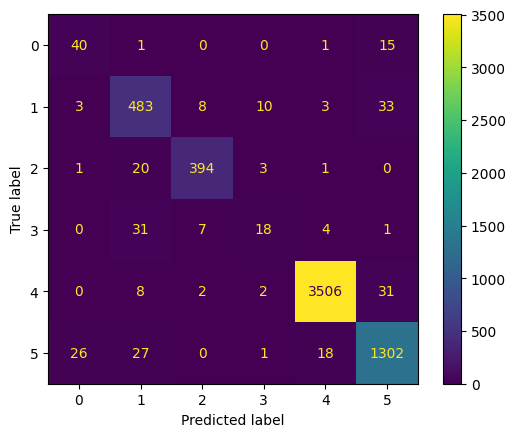

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test,voting_smote.predict(X_test))

*Observations*:
* Now, after resampling with SMOTE, the result has improved. 
* Less frquent classes are still getting misclassified in the similar manner but it is better than previous models.
* **Result on the Leaderboard is still best with the Voting Classifier without SMOTE.**

# Other Classifiers with SMOTE

In [39]:
#Making instance of XGB classifier.
xgb_classifier_smote=xgb.XGBClassifier(random_state=0)

#fitting the model and scoring on validation set
xgb_classifier_smote.fit(X_train_smote,y_train_smote)
xgb_classifier_smote.score(X_test,y_test)

0.958

In [42]:
#Making instance of Gradianet Boosting.
grad=GradientBoostingClassifier(random_state=0)

#fitting the model and scoring on validation set.
grad.fit(X_train_smote,y_train_smote)
grad.score(X_test,y_test)

0.9465

In [45]:
#Making instance of Gradianet Boosting.
rf_smote=RandomForestClassifier(random_state=0)

#fitting the model and scoring on validation set.
rf_smote.fit(X_train_smote,y_train_smote)
rf_smote.score(X_test,y_test)

0.9461666666666667

*Observations*:
* The results of Models after SMOTE are similar to that of before. 
* The XGBoost classfier is performing best till now with accuracy of **0.958** on the validation set that we have, but on the leaderbord (test set) Voting classifier without SMOTE is still leading for us.
* **Result on the Leaderboard is still best with the Voting Classifier without SMOTE.**

# Model Comparisions

**Let's plot the bar graph of accuracies on validation set of different models that we trained.**

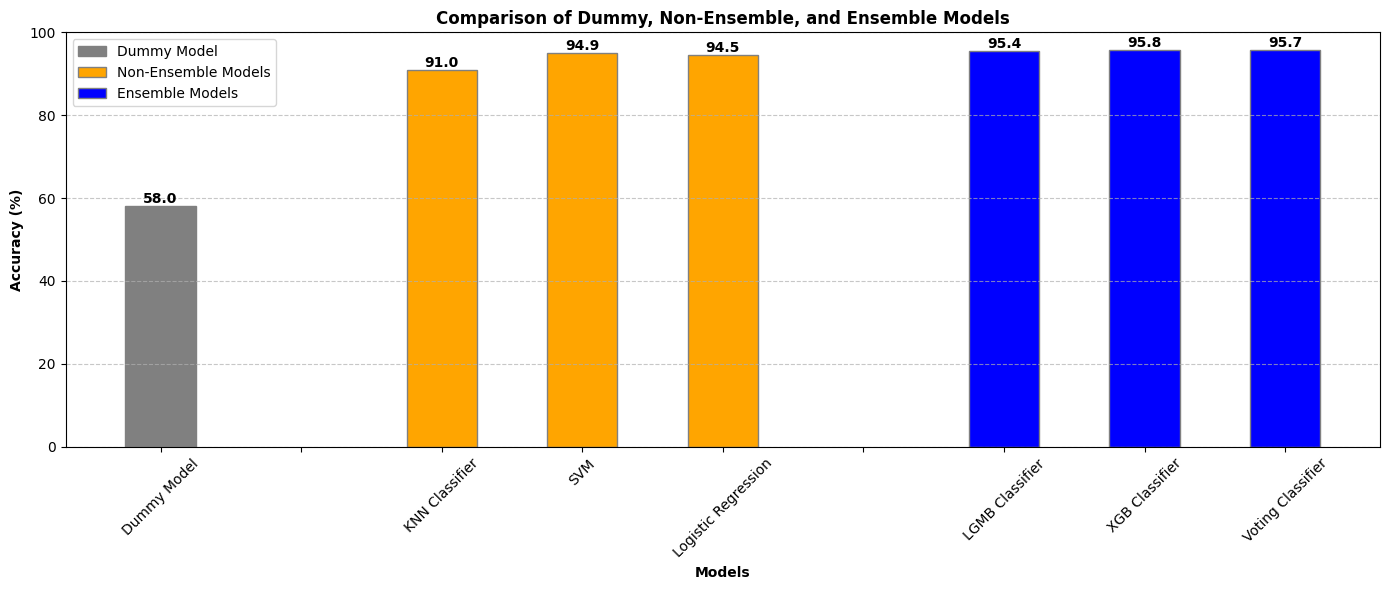

In [5]:
#Establishing the data for bar plot.
dummy_model = ['Dummy Model']
non_ensemble_models = ['KNN Classifier', 'SVM', 'Logistic Regression']
ensemble_models = ['LGMB Classifier', 'XGB Classifier', 'Voting Classifier']

#accuracies are multiplied with 100 for better understanding and visualisation.
dummy_accuracy = [58]
non_ensemble_accuracies = [91, 94.9, 94.5]
ensemble_accuracies = [95.4, 95.8, 95.7]

# Bar width
bar_width = 0.5

# X-axis positions for the bars
r1 = np.arange(len(dummy_model))
r2 = np.arange(len(non_ensemble_models)) + len(dummy_model) + 1
r3 = np.arange(len(ensemble_models)) + len(dummy_model) + len(non_ensemble_models) + 2

# Plotting the bars
plt.figure(figsize=(14, 6))
bars1 = plt.bar(r1, dummy_accuracy, color='grey', width=bar_width, edgecolor='grey', label='Dummy Model')
bars2 = plt.bar(r2, non_ensemble_accuracies, color='orange', width=bar_width, edgecolor='grey', label='Non-Ensemble Models')
bars3 = plt.bar(r3, ensemble_accuracies, color='blue', width=bar_width, edgecolor='grey', label='Ensemble Models')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Comparison of Dummy, Non-Ensemble, and Ensemble Models', fontweight='bold')

# Position x-tick labels for all sections
all_models = dummy_model + [''] + non_ensemble_models + [''] + ensemble_models
all_positions = list(r1) + [len(dummy_model)] + list(r2) + [len(dummy_model) + len(non_ensemble_models) + 1] + list(r3)

plt.xticks(all_positions, all_models, rotation=45)

# Set y-axis range
plt.ylim(0, 100)

# Adding a legend
plt.legend()

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', ha='center', va='bottom', fontweight='bold')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', ha='center', va='bottom', fontweight='bold')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', ha='center', va='bottom', fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

# Conclusion

1. In this project, we were assigned the crime dataset, where we were supposed to build a model that predicts the committed crime.

2. We started with the exploration of the dataset, where we observed certain behaviors of various features.

3. In preprocessing the dataset, we did some feature engineering and dropped some columns that were not necessary for the model. Then, we moved on to treating numerical and categorical columns, where we treated numerical columns with MinMaxScaler, and for categorical columns, we applied One-Hot encoding in the case of Non-Ensemble models and Ordinal encoding in the case of Ensemble models.

4. In model building, we started with Non-Ensemble models such as Logistic Regression, where we achieved a good accuracy of around 0.94.

5. We then moved to Ensemble models such as XGBoost and LGBM Classifier, where we observed better accuracy. We created a Voting classifier with these two classifiers and achieved a final accuracy of **0.9598** on the test set.

6. Upon observing the results in the confusion matrix and classification report, we realized that class imbalance was affecting the results. So, we tried applying the SMOTE sampling technique, but it did not surpass the best result we obtained previously.